# Chapter 15: Bonus, récurrent convolutional neuron network (RCNN)

### 15.1. Intuition behind CNN
### 15.2. Create an RCNN
### 15.3. Predictions and backtest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from Backtest import *

In [2]:
# Import the data
df = yf.download("GOOG", end="2021-01-01")[["Adj Close"]].pct_change(1)
df.columns = ["returns"]

# Features engeeniring
df["returns t-1"] = df[["returns"]].shift(1)

# Mean of returns
df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

# Volatility of returns
df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)

# Drop missing values
df = df.dropna()

# Percentage train set
split = int(0.80*len(df))

# Train set creation
X_train = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[:split]

y_train_reg = df[["returns"]].iloc[:split]

y_train_cla = np.round(df[["returns"]].iloc[:split]+0.5)


# Test set creation
X_test = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[split:]

y_test_reg = df[["returns"]].iloc[split:]
y_test_cla = np.round(df[["returns"]].iloc[split:]+0.5)


# NORMALIZATION 
# Import the class
from sklearn.preprocessing import StandardScaler

# Initialize the class
sc = StandardScaler()

# Standardize the data
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

def X_3d_RNN(X_s, y_s, lag):

    # Simple verification
    if len(X_s) != len(y_s):
        print("Warnings")

    # Create the X_train
    X_train = []
    for variable in range(0, X_s.shape[1]):
        X = []
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        X_train.append(X)
    X_train, np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    # Create the y_train
    y_train = []
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    y_train = np.concatenate(y_train, axis=0)
    return X_train, y_train




# STANDARDIZATION 
sc_y = StandardScaler()
y_train_scaled = sc_y.fit_transform(y_train_reg)
y_test_scaled = sc_y.transform(y_test_reg)

lag = 15
X_train_3d, y_train_3d = X_3d_RNN(X_train_scaled, y_train_scaled, 15)
X_test_3d, y_test_3d = X_3d_RNN(X_test_scaled, y_test_scaled, 15)

[*********************100%***********************]  1 of 1 completed


### 15.2. Create an RCNN

In [3]:
def RCNN(number_neurons, number_hidden_layer, shape, loss="mse", metrics=["mae"], activation="linear", optimizer="adam", pct_dropout=0.5):

    # LIBAIRIES
    import tensorflow
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv1D, Dense, LSTM, Dropout

    # INITIALIZATION OF THE DATA
    model = Sequential()

    # ADD LSTM LAYER
    model.add(LSTM(units = number_neurons, return_sequences = True, input_shape = shape))

    # ADD DROPOUT LAYER
    model.add(Dropout(pct_dropout))

    # LOOP WHICH ADD LSTM AND DROPPOUT LAYER
    for _ in range(number_hidden_layer):
        model.add(Conv1D(64,3, activation='relu'))
        model.add(LSTM(units = number_neurons, return_sequences = True))
        model.add(Dropout(pct_dropout))

    # LAST LSTM LAYER BUT WITH return_sequences = False
    model.add(LSTM(units = number_neurons, return_sequences = False))

    # OUTPUT DENSE LAYER
    model.add(Dense(1, activation=activation))

    # COMPILE THE MODEL
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

regressor = RCNN(15, 3, shape = (X_train_3d.shape[1],X_train_3d.shape[2]),
                  loss = "mse", metrics=["mae"], activation="linear",
                  optimizer="adam", pct_dropout=0.65)

regressor.fit(X_train_3d, y_train_3d, epochs=1, batch_size=32, verbose=1)

102/102 [==============================] - 10s 27ms/step - loss: 0.9229 - mae: 0.6329


### 15.3. Predictions and backtest

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.054 	 Alpha: 6.37 %	     Sharpe: 0.721 	 Sortino: 0.926
  -----------------------------------------------------------------------------
    VaR: 48.25 %	 cVaR: 59.27 % 	     VaR/cVaR: 1.229 	 drawdown: 30.79 %
  -----------------------------------------------------------------------------


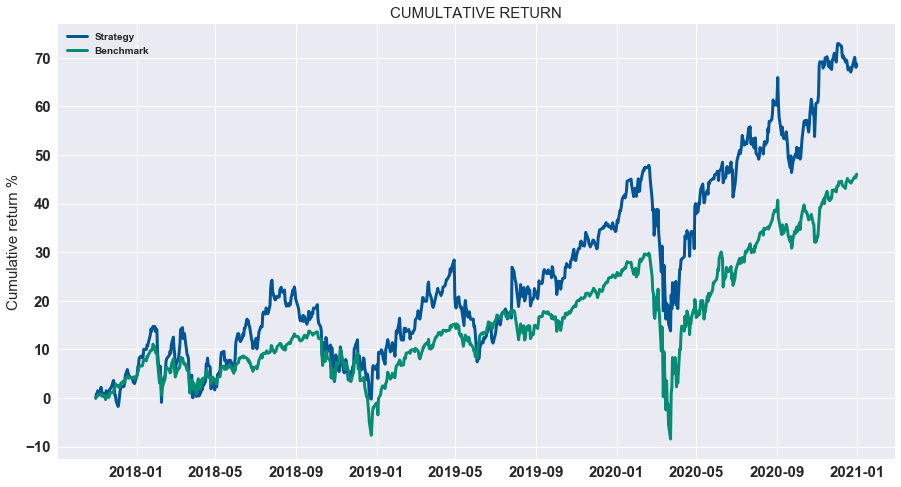

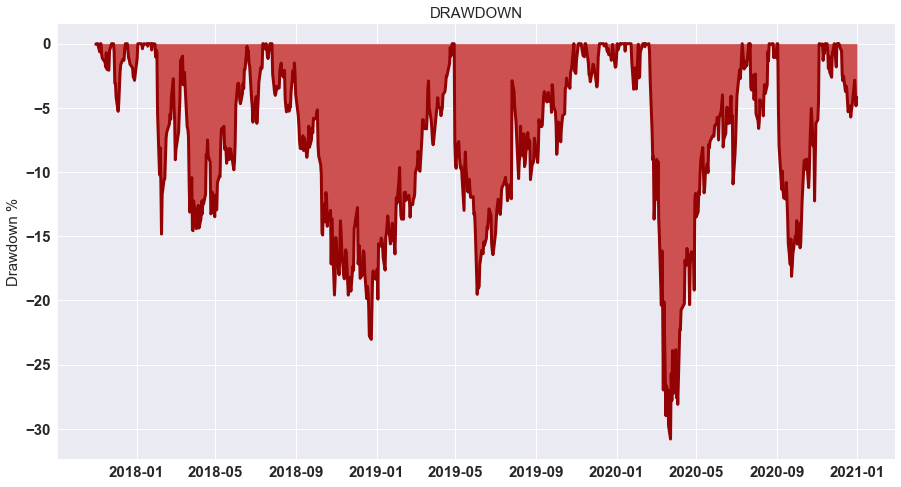

In [4]:
# Create predictions for the whole dataset

# Inverse transform
y_train_sc = sc_y.inverse_transform(regressor.predict(X_train_3d))

# Predictions
y_pred_train = np.concatenate((np.zeros([lag,1]),y_train_sc),
                                    axis=0)

# Inverse transform
y_test_sc = sc_y.inverse_transform(regressor.predict(X_test_3d))

# Predictions
y_pred_test = np.concatenate((np.zeros([lag,1]),y_test_sc),
                                    axis=0)


df["prediction"] = np.concatenate((y_pred_train,y_pred_test),
                                    axis=0)


# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split+lag:])